<a href="https://colab.research.google.com/github/sydney-ho/Airbnb-Analysis/blob/main/airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix



# EDA

In [172]:
df = pd.read_csv('AB_NYC_2019.csv')

In [173]:
df.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [175]:
# Remove unnecessary column
df.drop(['id','host_id', 'host_name','last_review', 'name', 'calculated_host_listings_count', 'availability_365'], axis=1, inplace=True)

In [176]:
# Drop rows with no prices:

df['price'].dropna(inplace=True)

In [177]:
# Define null items by columns

# This finds the percentage of null values by column
df.isnull().sum()/len(df)*100

neighbourhood_group     0.000000
neighbourhood           0.000000
latitude                0.000000
longitude               0.000000
room_type               0.000000
price                   0.000000
minimum_nights          0.000000
number_of_reviews       0.000000
reviews_per_month      20.558339
dtype: float64

In [178]:
# Clean data by accounting for null values, repalcing them with necessary values

df['reviews_per_month'].fillna(0, inplace=True)

In [179]:
df['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [180]:
cwd = os.getcwd()
path = cwd + '/final_clean_airbnb.csv'
df.to_csv(path, index=False)

In [181]:
import re

# Clean the Price Column
def clean_price(price):
    if price:
        numeric_price = re.sub("[^0-9.]", "", str(price))
        if numeric_price:
            return float(numeric_price)
    return None

df["price"] = df["price"].apply(clean_price)



In [182]:
# Filter out price values above 1200, denoted as outliers:

df = df[df["price"] <= 1200]

In [183]:
from math import radians, sin, cos, sqrt, atan2

# Add a new variable to track the distance from Times Square

# Define the coordinates of Times Square
ts_lat, ts_lon = 40.7589, -73.9851

# Define a function to calculate the distance between two coordinates using the Haversine formula
def distance(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the earth in km
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    a = sin(dLat/2) * sin(dLat/2) + cos(radians(lat1)) * cos(radians(lat2)) * sin(dLon/2) * sin(dLon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c
    return d

# Apply the distance function to calculate the distance between each property and Times Square
df['dist_from_manhattan'] = df.apply(lambda row: distance(row['latitude'], row['longitude'], ts_lat, ts_lon), axis=1)


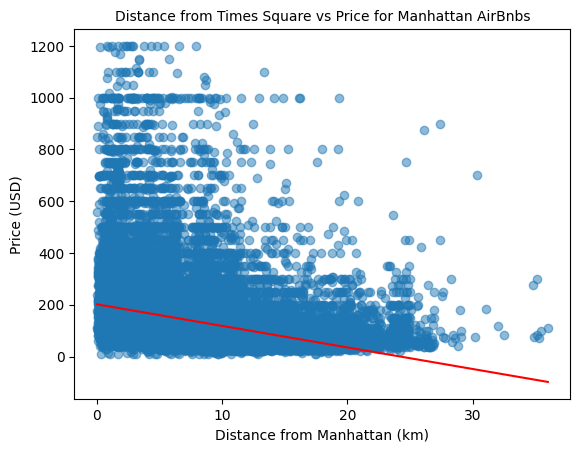

In [184]:
from scipy.stats import linregress

# Create a scatter plot of distance from Manhattan vs price
plt.scatter(df['dist_from_manhattan'], df['price'], alpha=0.5)
plt.title('Distance from Times Square vs Price for Manhattan AirBnbs', fontsize=10)
plt.xlabel('Distance from Manhattan (km)', fontsize=10)
plt.ylabel('Price (USD)', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
xticks_vals = np.linspace(0, 40, 5) # 0 to 40 in 4 equal increments
xticks_labels = [f'{x:.0f}' for x in xticks_vals]
plt.xticks(xticks_vals, xticks_labels)

# Calculate the slope and intercept of the line of best fit
slope, intercept, r_value, p_value, std_err = linregress(df['dist_from_manhattan'], df['price'])
x = np.array([df['dist_from_manhattan'].min(), df['dist_from_manhattan'].max()])
y = slope * x + intercept

# Plot the regression line over the scatter plot
plt.plot(x, y, color='r')

plt.show()

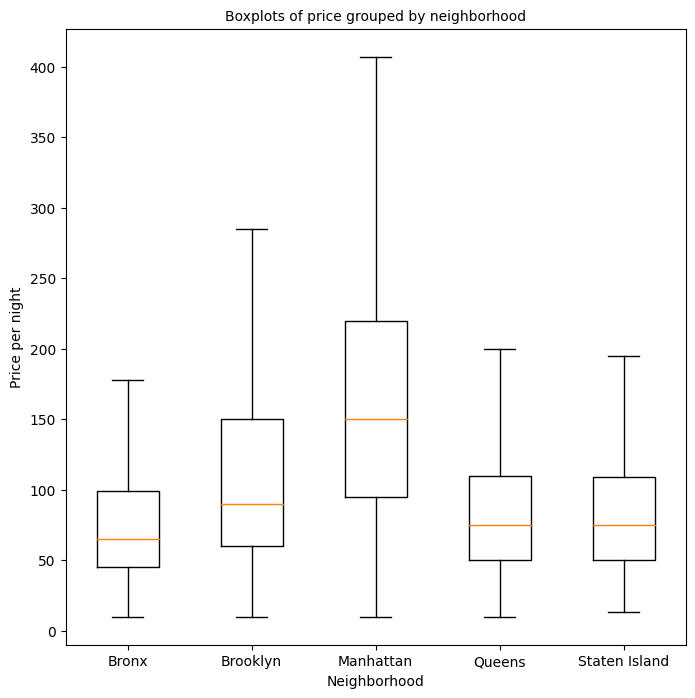

In [185]:
neighbourhood_group_price = df.groupby('neighbourhood_group').price

fig, ax = plt.subplots(figsize=(8, 8))
ax.boxplot([neighbourhood_group_price.get_group('Bronx'),
            neighbourhood_group_price.get_group('Brooklyn'),
            neighbourhood_group_price.get_group('Manhattan'),
            neighbourhood_group_price.get_group('Queens'),
            neighbourhood_group_price.get_group('Staten Island')],
            labels=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],showfliers=False)

ax.set_xlabel("Neighborhood", fontsize=10)
ax.set_ylabel("Price per night", fontsize=10)
ax.set_title("Boxplots of price grouped by neighborhood", fontsize=10)
ax.tick_params(axis='both', labelsize=10)

plt.show()

In [186]:
neighbourhood_group_price.describe()

count        mean         std   min   25%    50%  \
neighbourhood_group                                                       
Bronx                 1089.0   85.361800   77.761144  10.0  45.0   65.0   
Brooklyn             20050.0  118.303890   96.670552  10.0  60.0   90.0   
Manhattan            21526.0  180.638066  139.723956  10.0  95.0  150.0   
Queens                5656.0   95.008310   74.527596  10.0  50.0   75.0   
Staten Island          371.0   98.584906   96.138752  13.0  50.0   75.0   

                       75%     max  
neighbourhood_group                 
Bronx                 99.0  1000.0  
Brooklyn             150.0  1200.0  
Manhattan            220.0  1200.0  
Queens               110.0  1000.0  
Staten Island        109.0  1000.0

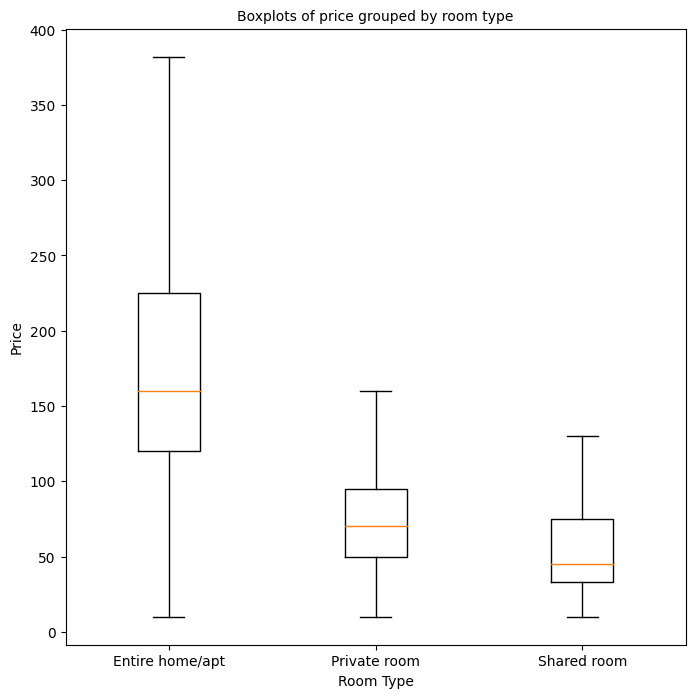

In [187]:
# Create boxplots grouped by room type

room_type_grouped_price = df.groupby('room_type').price.mean()

fig, ax = plt.subplots(figsize=(8, 8))
boxplot_data = [df[df['room_type'] == room_type]['price'] for room_type in room_type_grouped_price.index]
ax.boxplot(boxplot_data, labels=room_type_grouped_price.index, showfliers=False)

ax.set_xlabel("Room Type", fontsize=10)
ax.set_ylabel("Price", fontsize=10)
ax.set_title("Boxplots of price grouped by room type", fontsize=10)
ax.tick_params(axis='both', labelsize=10)

plt.show()

In [188]:
df.groupby('room_type').price.describe()

count        mean         std   min    25%    50%    75%  \
room_type                                                                     
Entire home/apt  25259.0  196.212914  131.844884  10.0  120.0  160.0  225.0   
Private room     22277.0   84.969655   70.064162  10.0   50.0   70.0   95.0   
Shared room       1156.0   67.731834   81.076816  10.0   33.0   45.0   75.0   

                    max  
room_type                
Entire home/apt  1200.0  
Private room     1200.0  
Shared room      1000.0

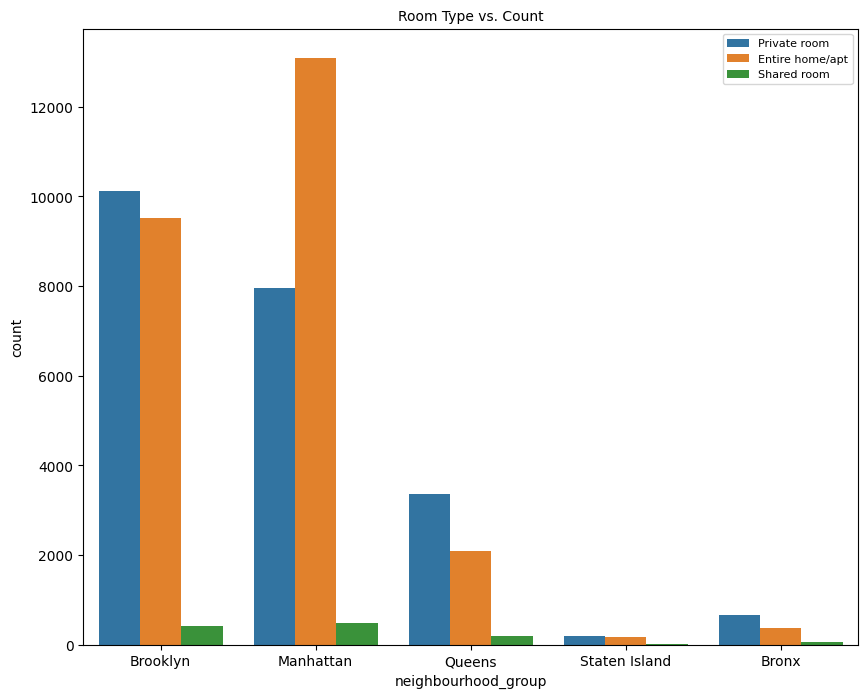

In [189]:
# Visualize how the neighborhood groups and room types relate

plt.figure(figsize=(10,8))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Room Type', fontsize=10)
plt.title('Room Type vs. Count', fontsize=10)
ax = sns.countplot(x=df['neighbourhood_group'],hue=df['room_type'])# here hue parameter will give us 3 diffrent colors
ax.legend(fontsize=8)

plt.show()

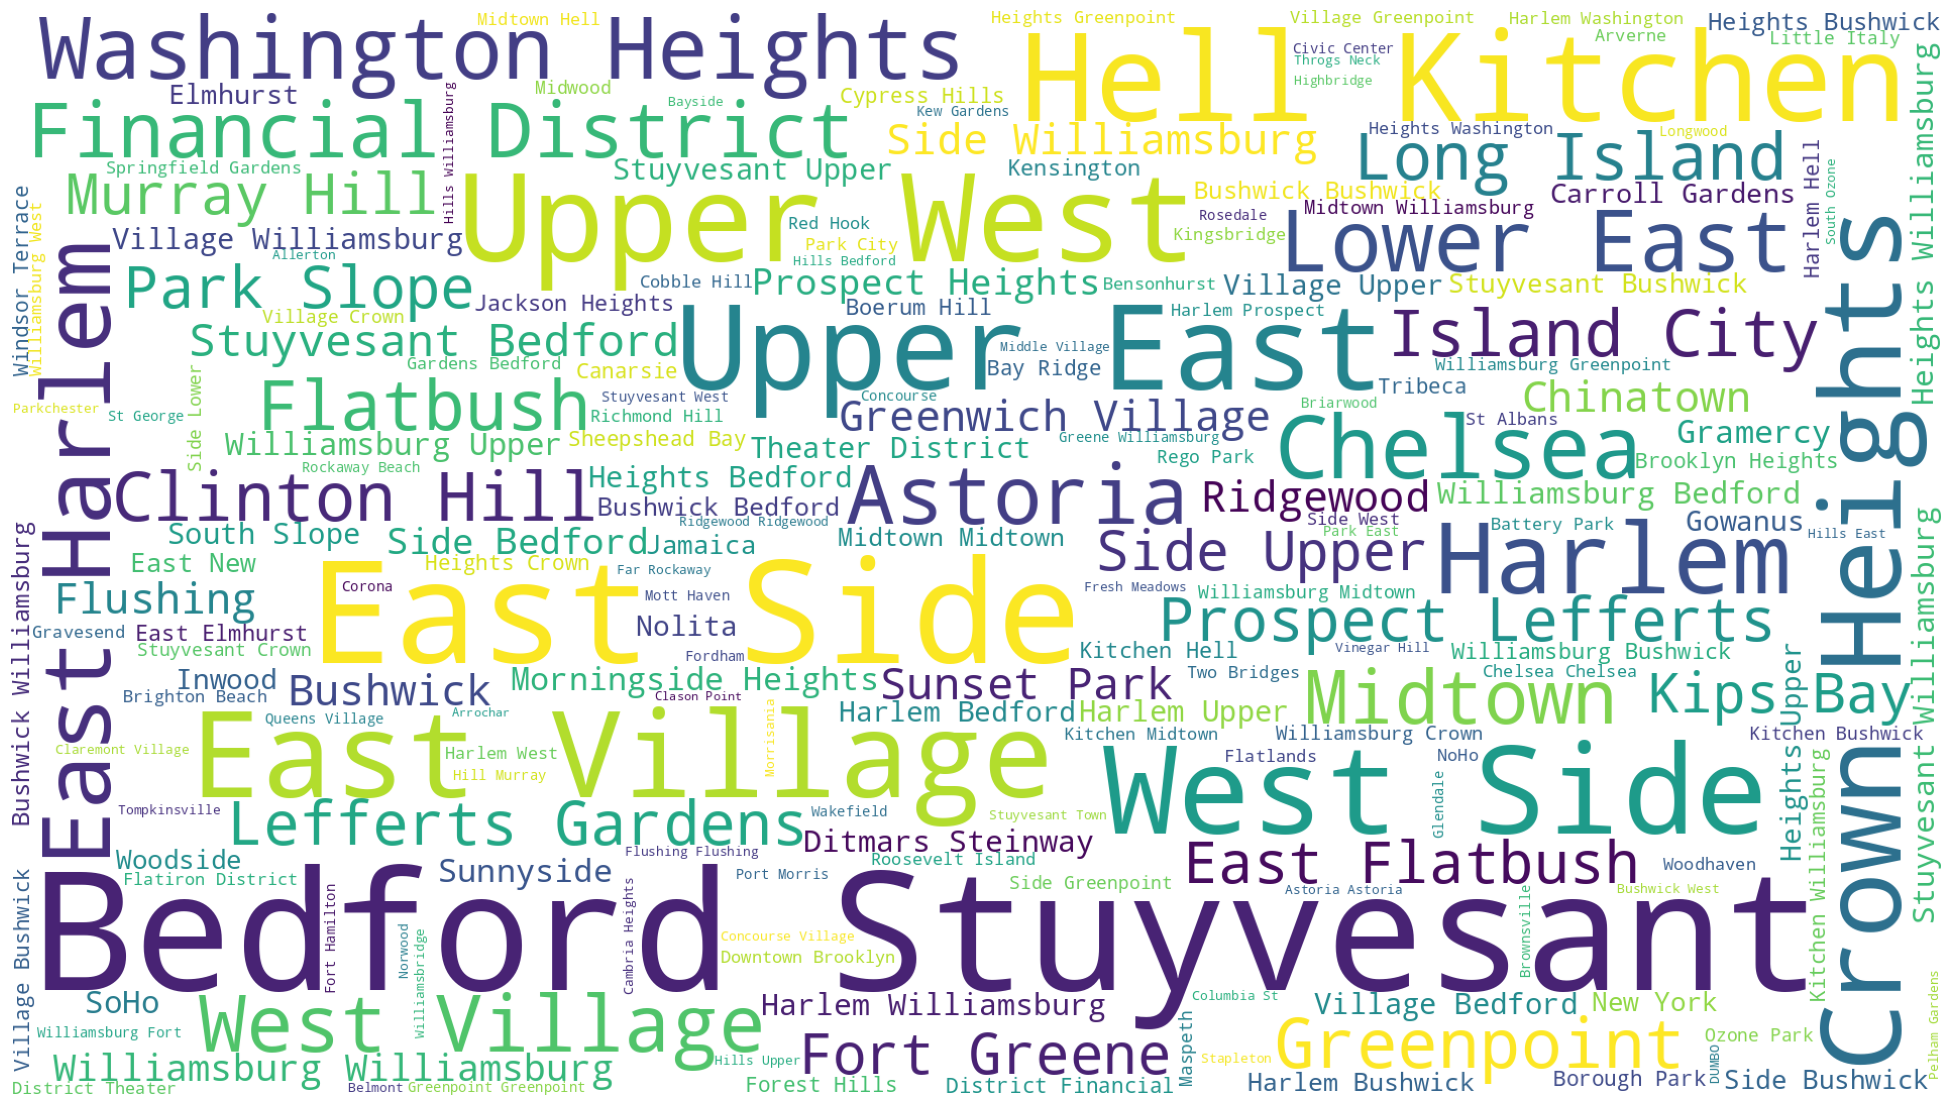

In [190]:
from wordcloud import WordCloud

plt.subplots(figsize=(25,15))
wordcloud = WordCloud(
                          background_color='white',
                          width=1920,
                          height=1080
                         ).generate(" ".join(df.neighbourhood))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('neighbourhood.png')
plt.show()

In [191]:
data = df.neighbourhood.value_counts()[:10]
plt.figure(figsize=(12, 8))
x = list(data.index)
y = list(data.values)
x.reverse()
y.reverse()

plt.title("Most Popular Neighbourhood", fontsize=10)
plt.ylabel("Neighbourhood Area", fontsize=10)
plt.xlabel("Number of guest Who host in this Area", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.barh(x, y)

<BarContainer object of 10 artists>

<ipython-input-32-051b6feb5fd7>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

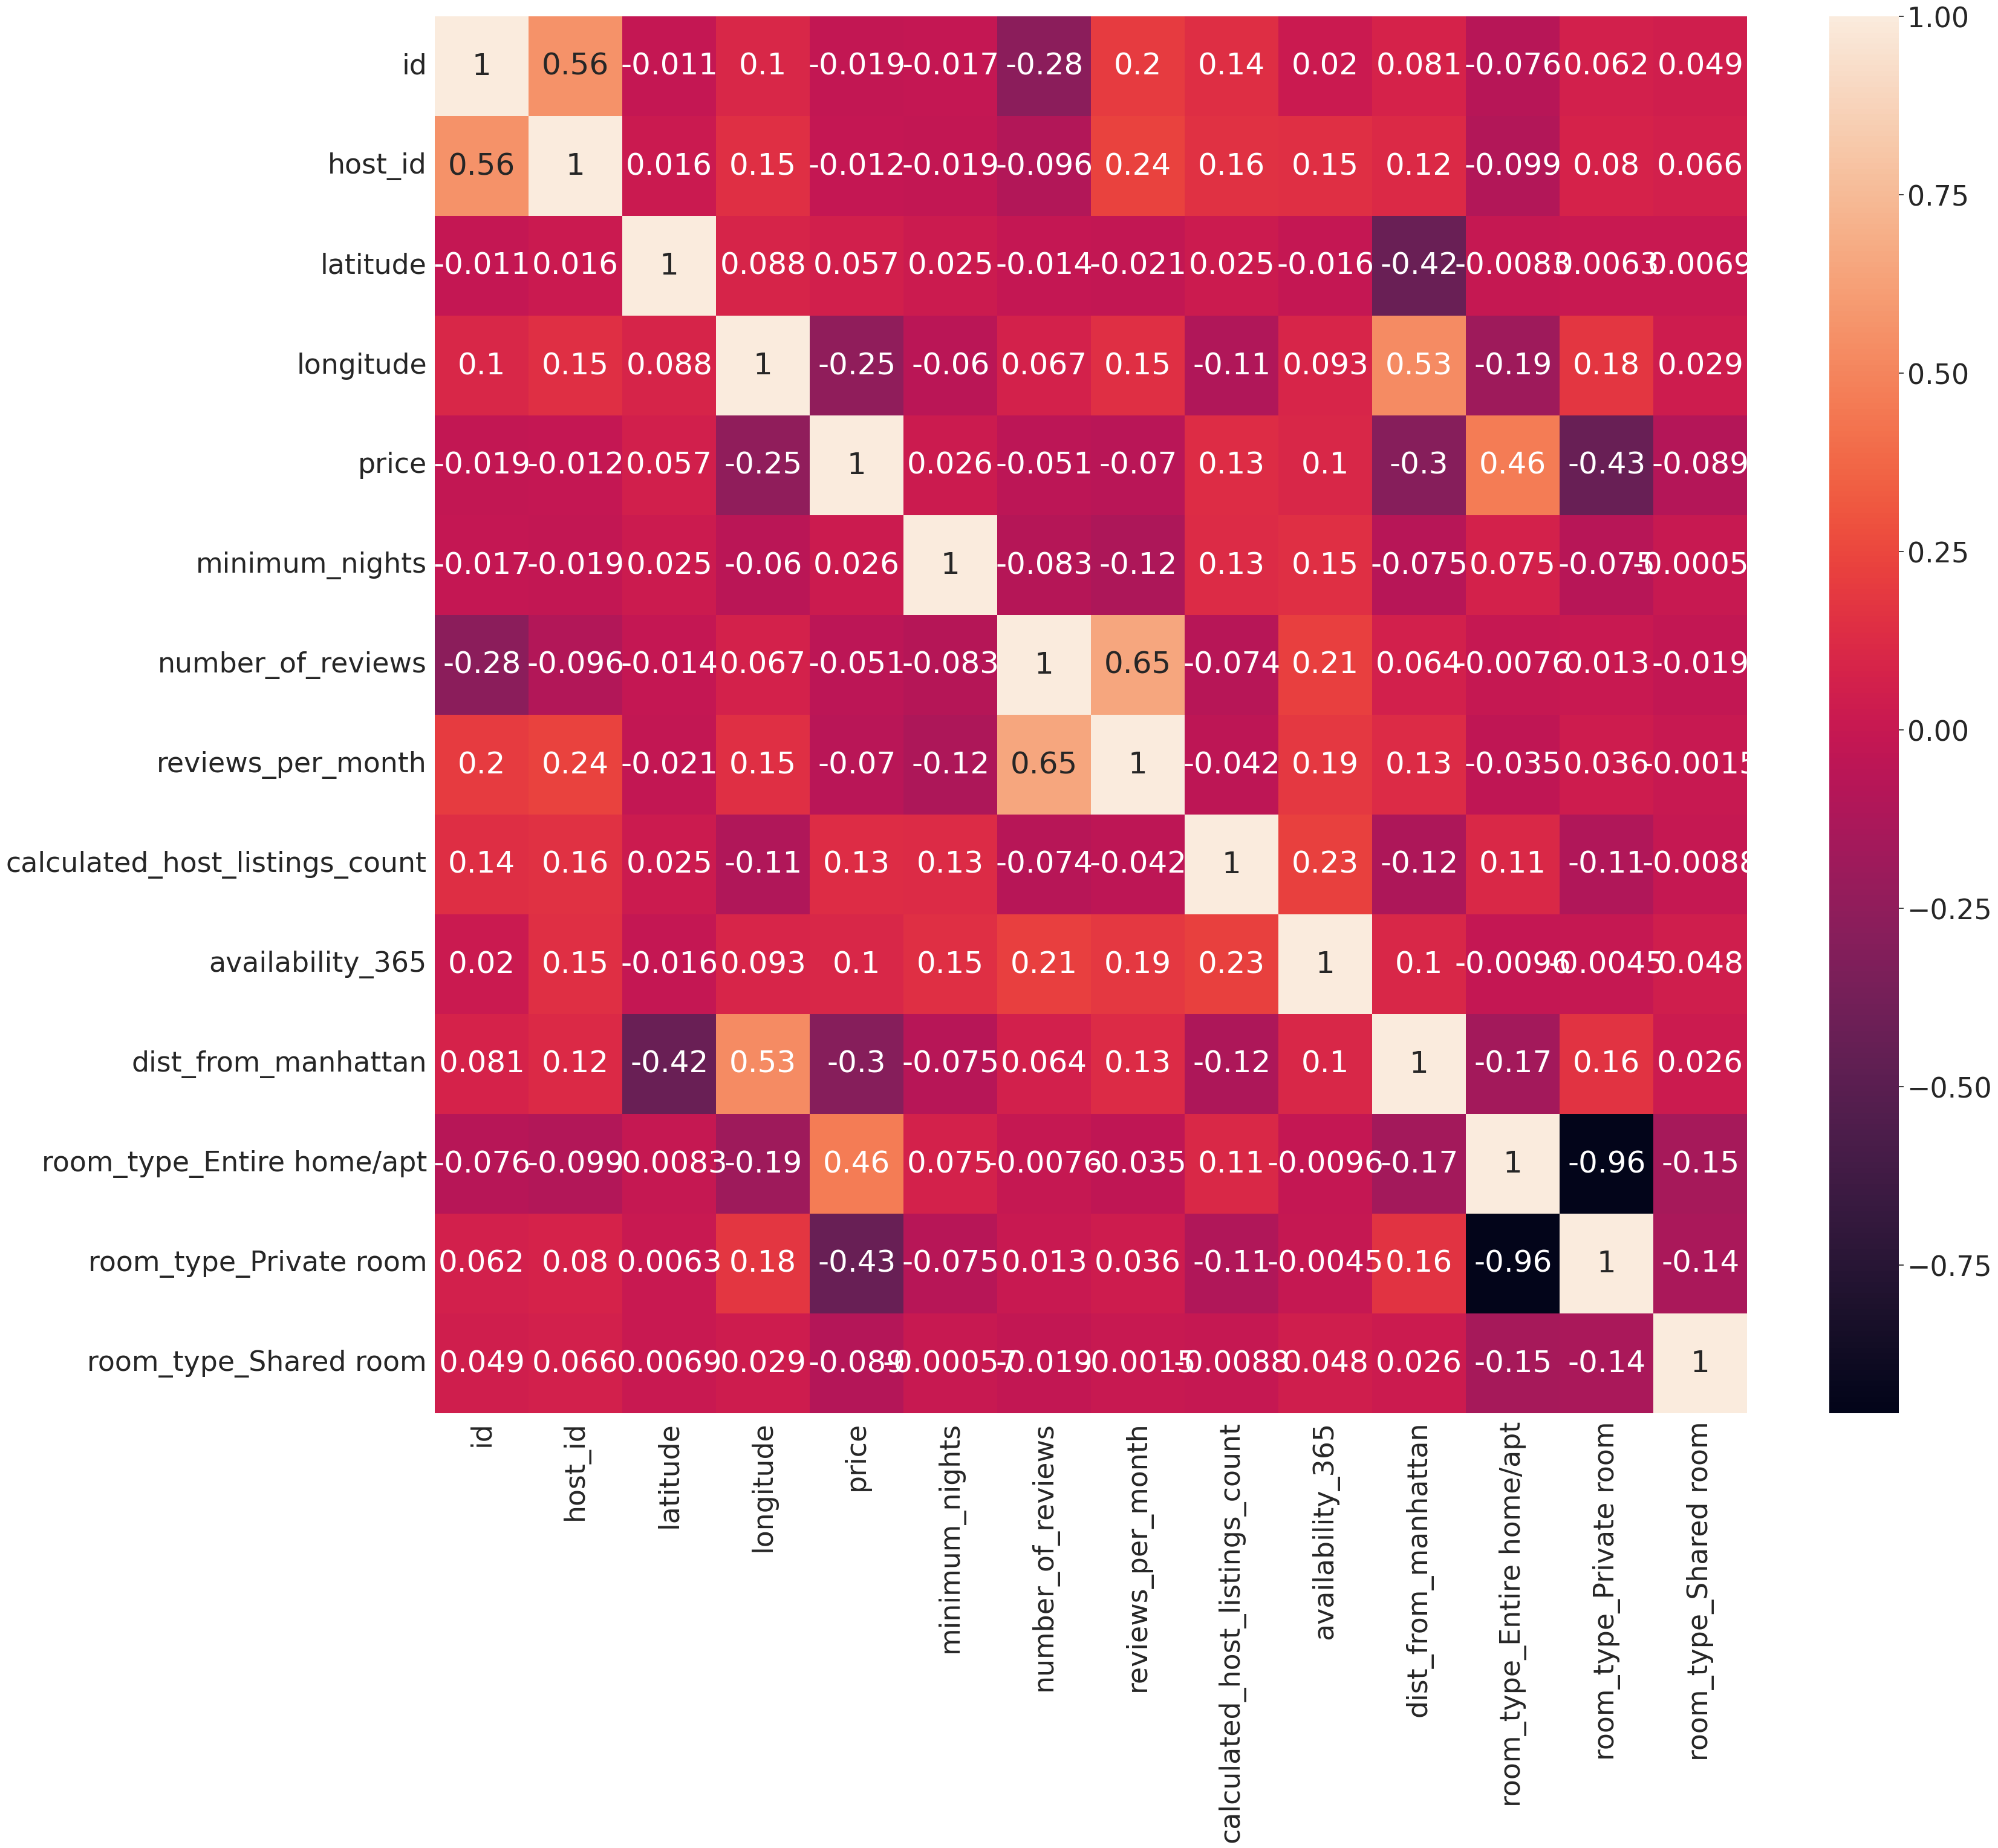

In [ ]:
# Plot a correlation matrix to see how the variables interact
sns.set(font_scale=3)
plt.figure(figsize=(35, 30))
sns.heatmap(df.corr(), annot=True)

In [192]:
# Fixed Linear Regression to Predict Prices:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import f_oneway


plt.figure(figsize=(10,6))
sns.scatterplot(x=df.longitude, y=df.latitude, hue=df.neighbourhood_group)
plt.ioff()

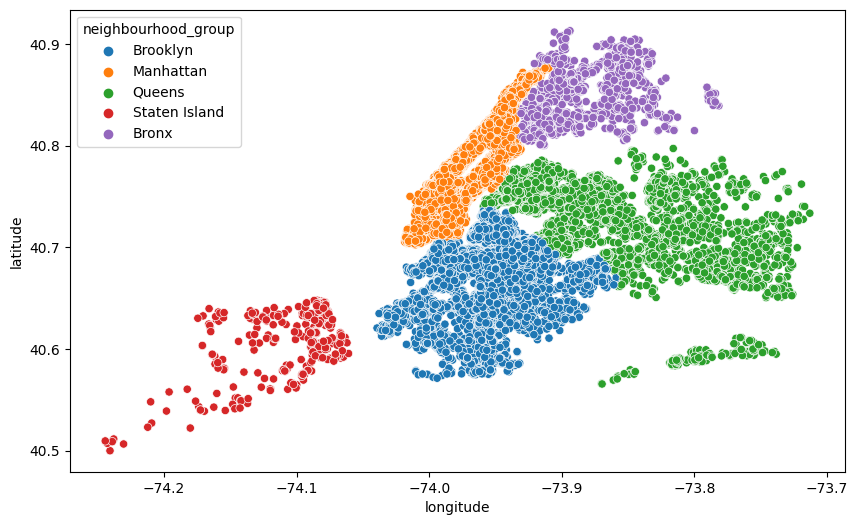

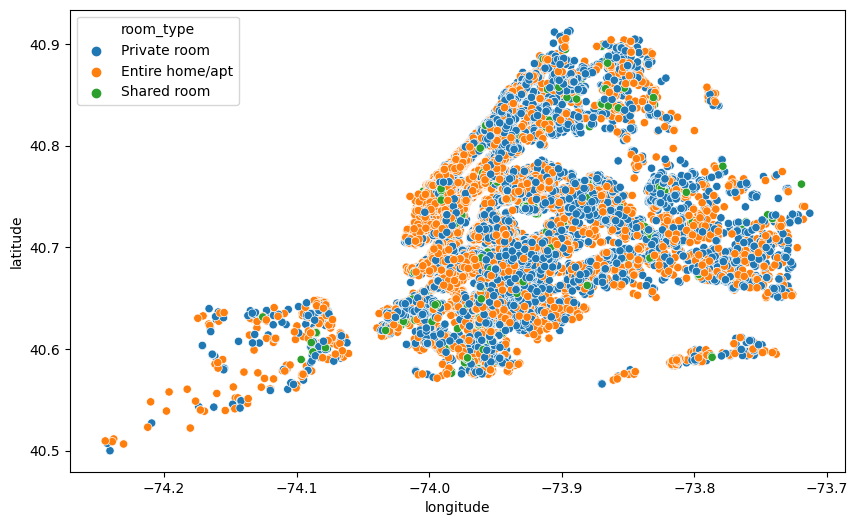

In [ ]:
# Scatter plot of room types

plt.figure(figsize=(10,6))
sns.scatterplot(x=df.longitude,y=df.latitude,hue=df.room_type)
plt.ioff()
plt.show()

In [193]:
# Get rid of unnecessary columns for regression analysis:
df.drop(['latitude','longitude','neighbourhood','number_of_reviews','reviews_per_month'], axis=1, inplace=True)

In [194]:
# Check out the remaining data
df

neighbourhood_group        room_type  price  minimum_nights  \
0                Brooklyn     Private room  149.0               1   
1               Manhattan  Entire home/apt  225.0               1   
2               Manhattan     Private room  150.0               3   
3                Brooklyn  Entire home/apt   89.0               1   
4               Manhattan  Entire home/apt   80.0              10   
...                   ...              ...    ...             ...   
48890            Brooklyn     Private room   70.0               2   
48891            Brooklyn     Private room   40.0               4   
48892           Manhattan  Entire home/apt  115.0              10   
48893           Manhattan      Shared room   55.0               1   
48894           Manhattan     Private room   90.0               7   

       dist_from_manhattan  
0                12.434617  
1                 0.597701  
2                 6.654962  
3                 8.475184  
4                 5.601876  
...                    ...  
48890             9.414918  
48891             7.707357  
48892             6.926322  
48893             0.530080  
48894             0.673486  

[48692 rows x 5 columns]

<ipython-input-195-24cc7139c786>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'], fit=stats.norm)


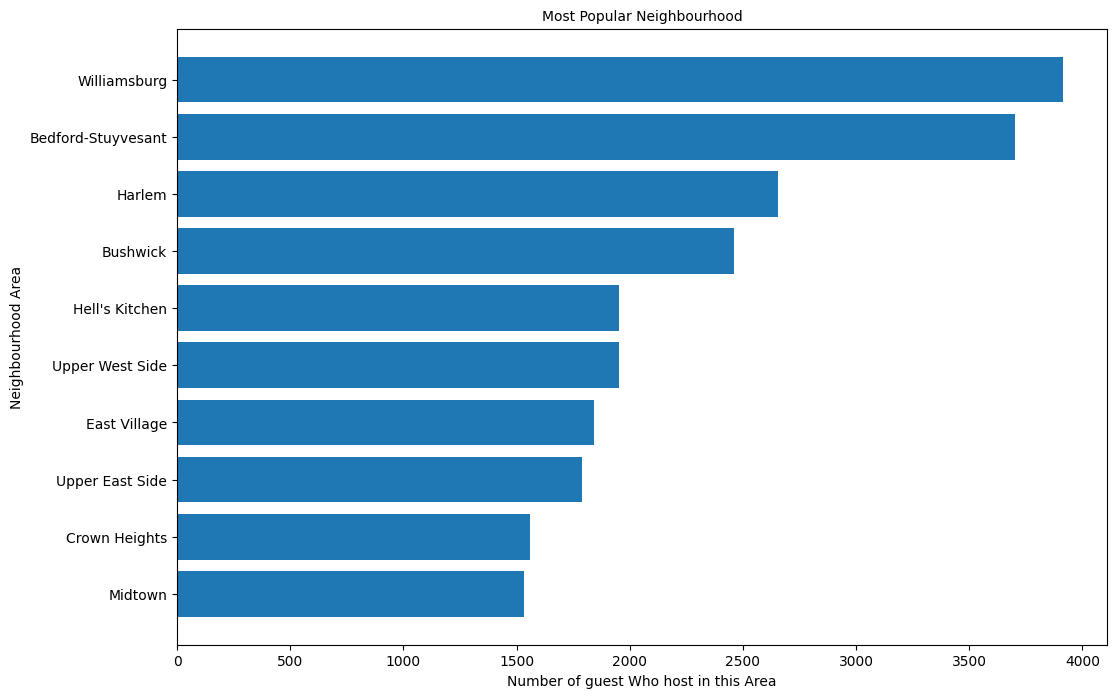

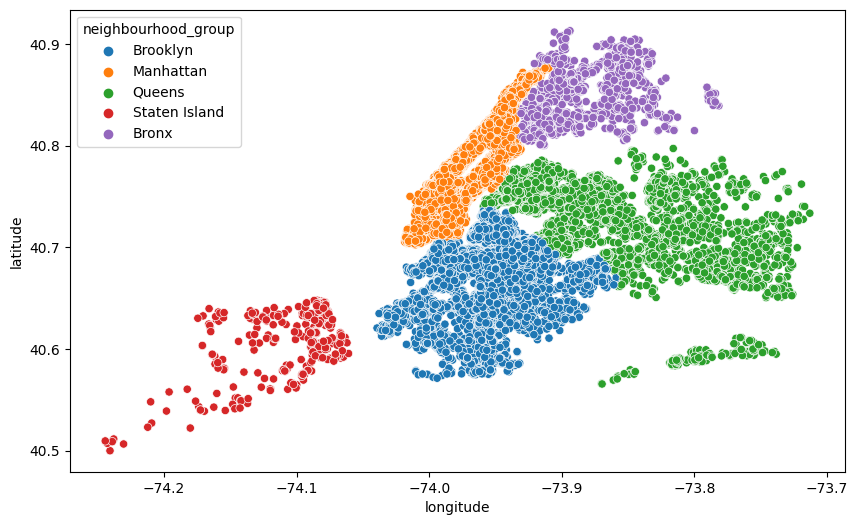

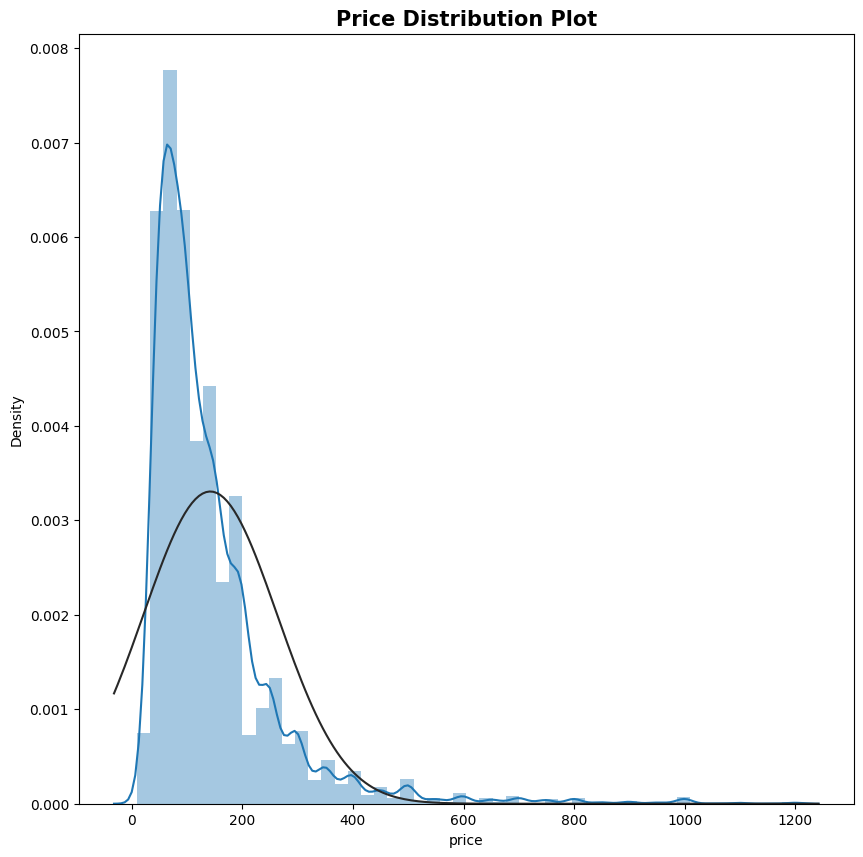

In [195]:
from scipy import stats

plt.figure(figsize=(10,10))
sns.distplot(df['price'], fit=stats.norm)
plt.title("Price Distribution Plot",size=15, weight='bold')
plt.show()

<ipython-input-196-97df94dac75b>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price_log'], fit=stats.norm)


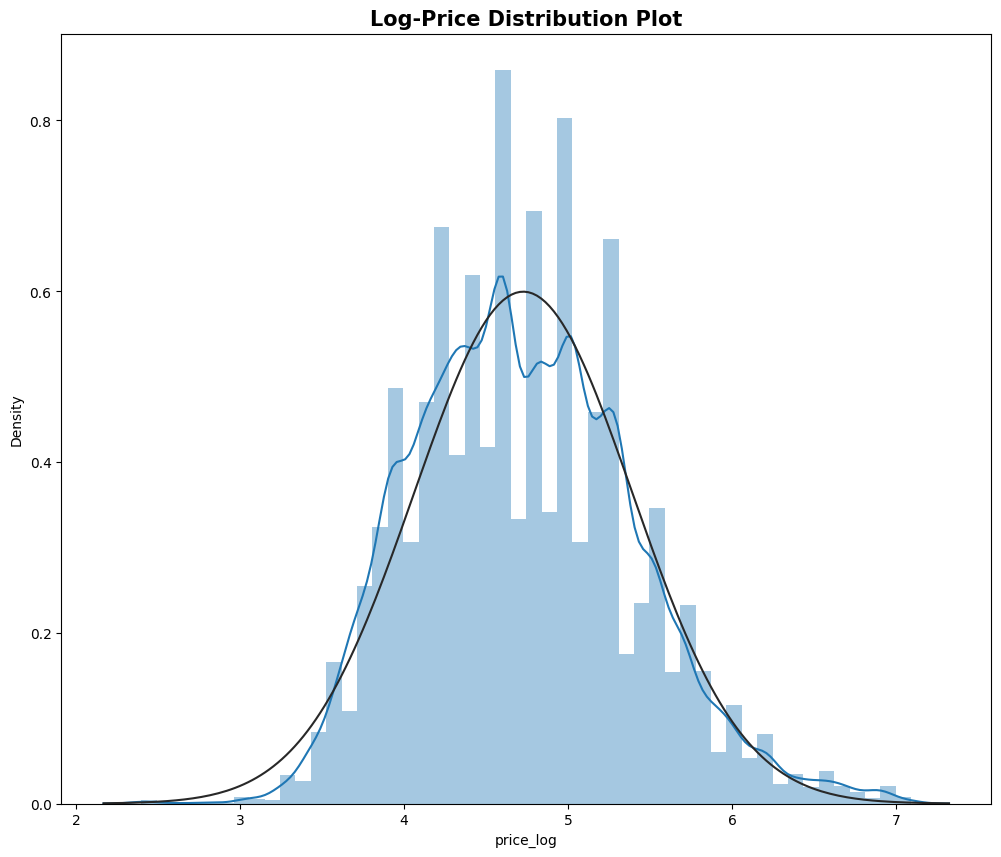

In [196]:
# Add a column for the log of the price

df['price_log'] = np.log(df.price+1)

plt.figure(figsize=(12,10))
sns.distplot(df['price_log'], fit=stats.norm)
plt.title("Log-Price Distribution Plot",size=15, weight='bold')
plt.show()

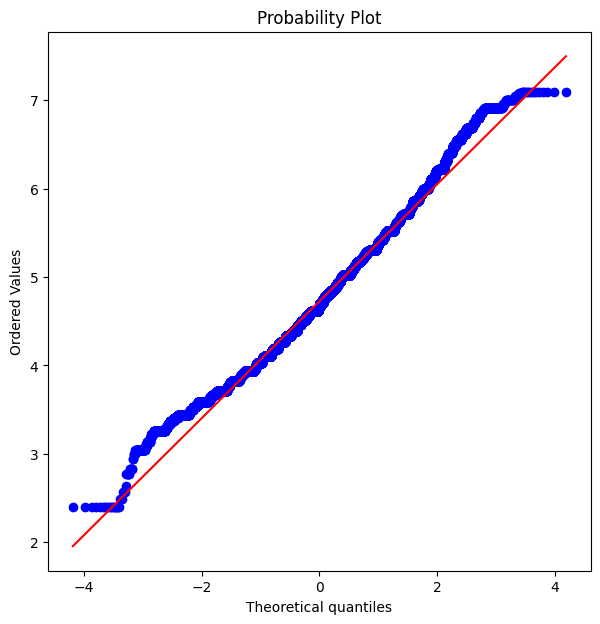

In [ ]:
# See if this is a good fit

plt.figure(figsize=(7,7))
stats.probplot(df['price_log'], plot=plt)
plt.show()

In [200]:
# Categorize the neighbourhood groups and room_types into specific numbers

df['room_type'] = df['room_type'].astype('category').cat.codes
df['neighbourhood_group'] = df['neighbourhood_group'].astype('category').cat.codes

# Linear Regression For Prediction


In [249]:
#Defining the independent variables and dependent variables
x = df.iloc[:,[0,1,3,4]]
y = df['price']

#Getting Test and Training Set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.1,random_state=500)
x_train.head()
y_train.head()

2395      70.0
32967    112.0
11975    181.0
23442     60.0
15991    120.0
Name: price, dtype: float64

In [250]:
#Prepare a Linear Regression Model
import statsmodels.api as sm
from sklearn.metrics import r2_score

# Fit the linear regression model using sm.OLS
model = sm.OLS(y_train, sm.add_constant(x_train))
result = model.fit()

# Generate predictions on the test set using the fitted model
y_pred = result.predict(sm.add_constant(x_test))

# Calculate the R-squared score
r2_score(y_test, y_pred)

0.26366282234658156

In [251]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     3855.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        23:48:54   Log-Likelihood:            -2.6579e+05
No. Observations:               43822   AIC:                         5.316e+05
Df Residuals:                   43817   BIC:                         5.316e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 227.2334      1.624    139.932      0.000     224.051     230.416
neighbourhood_group     5.0639      0.683      7.412      0.000       3.725       6.403
room_type             -91.6517      0.927    -98.838      0.000     -93.469     -89.834
minimum_nights         -0.1409      0.024     -5.842      0.000      -0.188      -0.094
dist_from_manhattan    -6.4338      0.115    -55.842      0.000      -6.660      -6.208
==============================================================================
Omnibus:                    35972.949   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1025502.966
Skew:                           3.860   Prob(JB):                         0.00
Kurtosis:                      25.406   Cond. No.                         76.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [252]:
# Look at the errors:
error_airbnb = pd.DataFrame({
        'Actual Values': np.array(y_test).flatten(),
        'Predicted Values': y_pred.values.flatten()}).head(40)

error_airbnb.head(5)

Actual Values  Predicted Values
0          200.0        194.738877
1           80.0        170.176531
2           75.0         69.889446
3           45.0         73.840567
4           48.0        100.327474

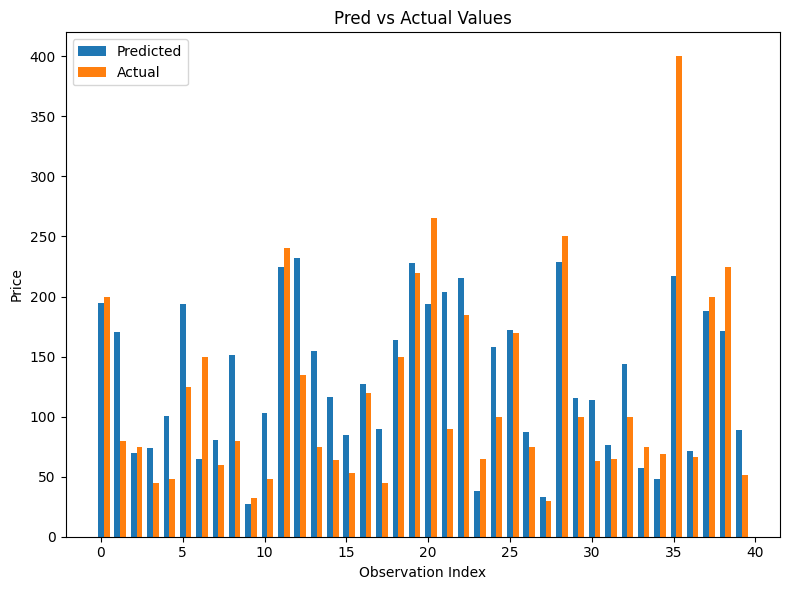

In [253]:
import matplotlib.pyplot as plt

# Set the x-axis labels
x_labels = error_airbnb.index
bar_width = 0.35

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x_labels, error_airbnb['Predicted Values'], width=bar_width, label='Predicted')
ax.bar(x_labels + bar_width, error_airbnb['Actual Values'], width=bar_width, label='Actual')
ax.set_title('Pred vs Actual Values')
ax.set_xlabel('Observation Index')
ax.set_ylabel('Price')

# Add the legend and adjust the layout
ax.legend()
fig.tight_layout()
plt.show()

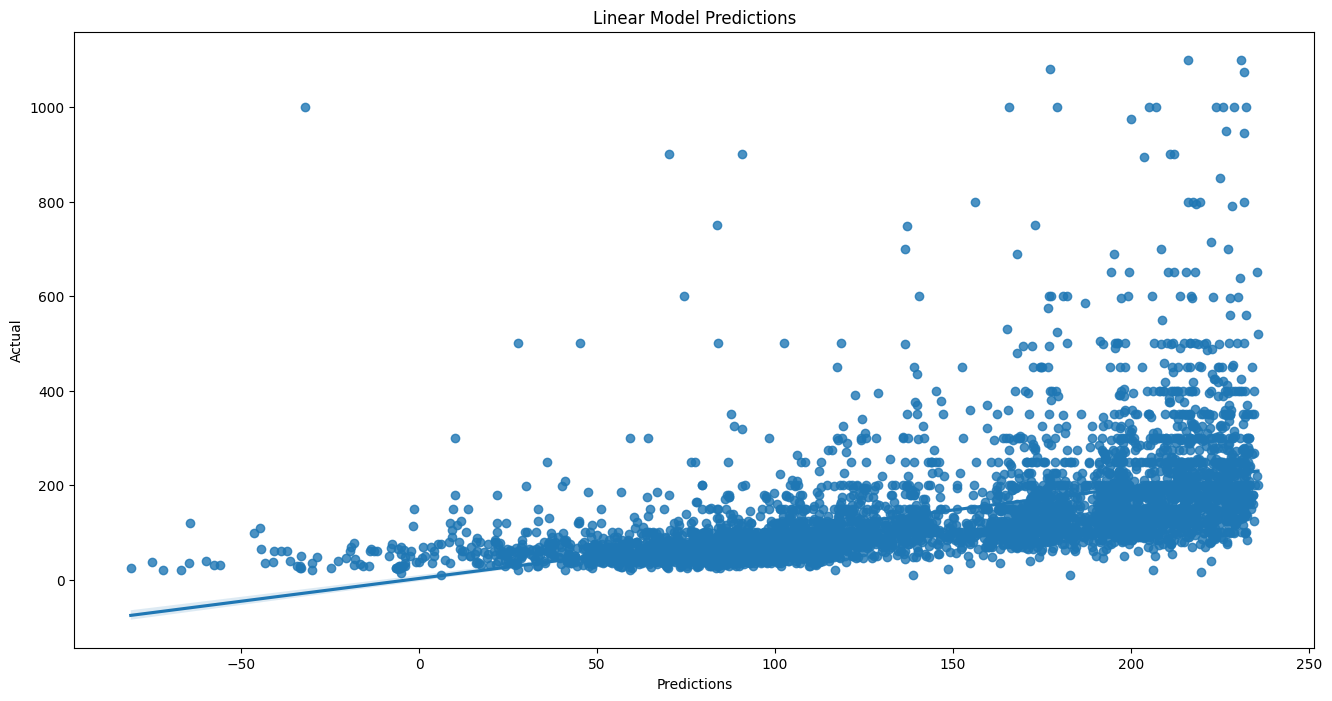

In [254]:
plt.figure(figsize=(16,8))
sns.regplot(x=y_pred,y=y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Linear Model Predictions")
plt.grid(False)
plt.show()

# REDO IT BUT GET RID OF OUTLIERS

In [232]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

In [233]:
no_outlier_df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
no_outlier_df.shape

(38286, 6)

In [234]:
no_outlier_df.describe()

neighbourhood_group     room_type         price  minimum_nights  \
count         38286.000000  38286.000000  38286.000000    38286.000000   
mean              1.616962      0.546806    120.069817        2.717364   
std               0.712172      0.543753     67.200521        1.869496   
min               0.000000      0.000000     18.000000        1.000000   
25%               1.000000      0.000000     68.000000        1.000000   
50%               2.000000      1.000000    100.000000        2.000000   
75%               2.000000      1.000000    158.000000        3.000000   
max               3.000000      2.000000    334.000000       11.000000   

       dist_from_manhattan     price_log  
count         38286.000000  38286.000000  
mean              7.053368      4.644864  
std               3.729181      0.557841  
min               0.036285      2.944439  
25%               4.183427      4.234107  
50%               6.725152      4.615121  
75%               9.458598      5.068904  
max              17.867409      5.814131

In [235]:
# Redo it without outliers:
Y = no_outlier_df['price']
X = no_outlier_df[['neighbourhood_group', 'room_type', 'minimum_nights', 'dist_from_manhattan']]

#Getting Test and Training Set
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=.1,random_state=500)
x_train.head()
y_train.head()

27724    255.0
20876     95.0
38957     35.0
25503     75.0
35952    120.0
Name: price, dtype: float64

In [236]:
# Fit the linear regression model using sm.OLS
model2 = sm.OLS(y_train, sm.add_constant(x_train))
result2 = model2.fit()

# Generate predictions on the test set using the fitted model
y_pred2 = result.predict(sm.add_constant(x_test))

# Calculate the R-squared score
r2_score(y_test, y_pred2)

0.333630581031122

In [237]:
# Model Summary

result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     7323.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        23:45:30   Log-Likelihood:            -1.8325e+05
No. Observations:               34457   AIC:                         3.665e+05
Df Residuals:                   34452   BIC:                         3.665e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 205.7543      1.132    181.837      0.000     203.536     207.972
neighbourhood_group    -1.4872      0.399     -3.732      0.000      -2.268      -0.706
room_type             -70.0557      0.499   -140.427      0.000     -71.034     -69.078
minimum_nights         -1.6464      0.145    -11.388      0.000      -1.930      -1.363
dist_from_manhattan    -5.7356      0.077    -74.810      0.000      -5.886      -5.585
==============================================================================
Omnibus:                     6184.435   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11762.392
Skew:                           1.112   Prob(JB):                         0.00
Kurtosis:                       4.802   Cond. No.                         37.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [247]:
error_airbnb = pd.DataFrame({
        'Actual Values': np.array(y_test).flatten(),
        'Predicted Values': y_pred2.values.flatten()}).head(40)

error_airbnb.head(5)

Actual Values  Predicted Values
0          130.0        231.247227
1          200.0        221.931764
2          125.0         86.861830
3          170.0        215.385141
4           55.0         78.347648

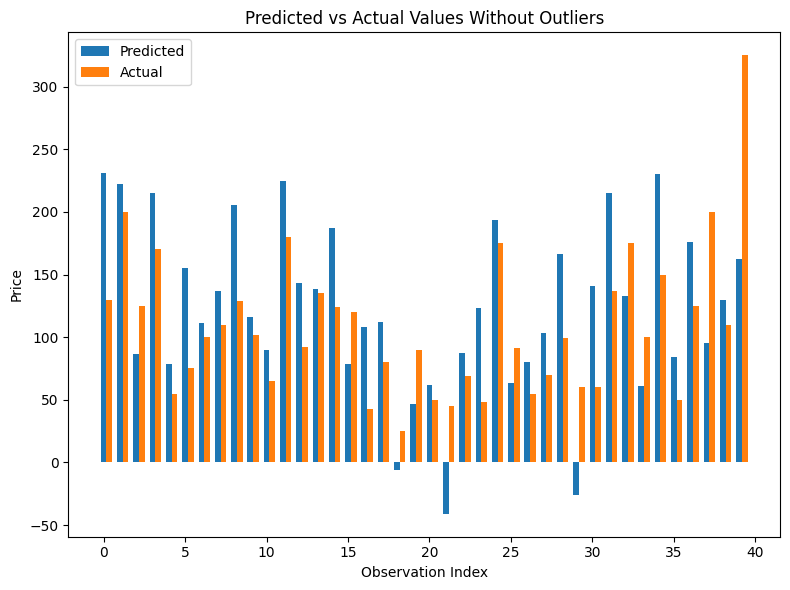

In [248]:
import matplotlib.pyplot as plt

# Set the x-axis labels
x_labels = error_airbnb.index
bar_width = 0.35

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x_labels, error_airbnb['Predicted Values'], width=bar_width, label='Predicted')
ax.bar(x_labels + bar_width, error_airbnb['Actual Values'], width=bar_width, label='Actual')
ax.set_title('Predicted vs Actual Values Without Outliers')
ax.set_xlabel('Observation Index')
ax.set_ylabel('Price')

ax.legend()
fig.tight_layout()
plt.show()

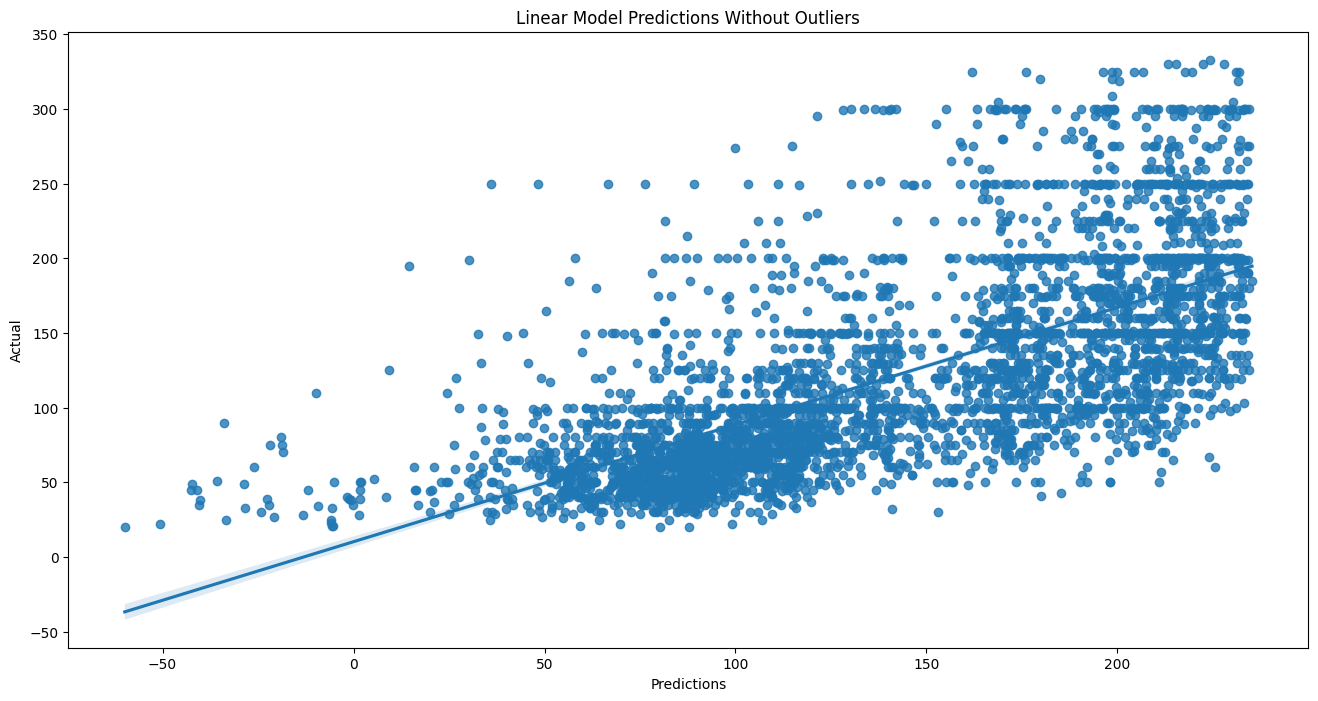

In [241]:
plt.figure(figsize=(16,8))
sns.regplot(x=y_pred2,y=y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Linear Model Predictions Without Outliers")
plt.grid(False)
plt.show()